# **Simulation of a crack growth in a square plate based on Peridynamic Theory**

Silling, S. A., & Askari, E. (2005). *A meshfree method based on the peridynamic model of solid mechanics*. *Computers & Structures, 83*(17-18), 1526-1535. https://doi.org/10.1016/j.compstruc.2004.11.026

## Setup

### Load Python Libraries

- **NumPy:** This library is fundamental for numerical computations in Python. It provides support for arrays, matrices, and many mathematical functions that operate on these data structures.
- **Matplotlib:** A plotting library for creating static, animated, and interactive visualizations in Python. It's particularly useful for generating plots, histograms, and other types of charts.
- **Pandas:** A Python library used for working with data sets. It has functions for analyzing, cleaning, exploring, and manipulating data.
- **Seaborn:** This Python library helps users visualize data through statistical graphics.
- **Celluloid:** This Python library simplifies the process of creating animations by capturing each frame in Matplotlib.
- **IPython.display.HTML:** This module from IPython is used to display rich HTML content within Jupyter notebooks, helpful for embedding animations and media.
- **PillowWriter:** This writer class in Matplotlib saves animations in GIF format, particularly useful when working with the FuncAnimation class to create smooth animations.

In [1]:
import numpy as np  
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib import cm
import pandas as pd  
import seaborn as sns
from celluloid import Camera
from IPython.display import HTML

## Parameters

<center><img src="fig4-square_plate_containing_an_initial_center_crack.gif"/></center>
<br><br> <center> Figure - Square Plate Containing an Initial Center Crack (Silling & Askari, 2005) </center>

In [17]:
#Define the dimensions of the 2D Plate
length = 0.05                #Length of the plate
width = 0.05                 #width of the plate

#Definte the number of nodes in x & y directions
nx = 50                     #Number of nodes in x-direction
ny = 50                     #Number of nodes in y-direction

#Crack
a0 = 0.005                  #Half length of the initial center crack 
crack_length = 2 * a0       #Total length of the initial center crack

#Other Properties  
dx = length/nx              #Spacing
num_boundary_rows = 3       #Number of boundary regions
total_nodes = nx * (ny + (num_boundary_rows*2)) #Total number of nodes in the 2D plate
delta_x = 3.015 * dx          #Horizon
radius_of_node = dx / 2     #Radius around the node
area_of_node = dx * dx      #Area of the radius around the node
vol = area_of_node * dx     #Volume of the node
thick = dx                  #Total thickness of the plate
rho = 8000                 #rhoity
E = 192e9                   #Elastic Modulus
poisson_ratio = 1/3         #Poisson's ratio
k = E / (3*(1-2*poisson_ratio))
c = 18 * k / np.pi / delta_x**4
#c = (9 * E ) / (np.pi * thick * delta_x**3) #Material constant

critical_stretch = 1     #Critical stretch for bond fail_matrixure

#Time
total_time = 15e-6             #Total time of simulation
delta_t = 1.2e-8
"""
k = E / (3 * ( 1- (2*poisson_ratio)))
c = (18*k)/(np.pi*delta_x**4)
delta_t = np.sqrt(2*rho/(c*vol))
delta_t
"""
total_time_steps = int(total_time/delta_t)

## Create Grid Geometry

In [3]:
# Generate internal region points
x_internal = np.linspace(-length / 2 + dx / 2, length / 2 - dx / 2, nx)
y_internal = np.linspace(-width / 2 + dx / 2, width / 2 - dx / 2, ny)
X_internal, Y_internal = np.meshgrid(x_internal, y_internal)
internal_points = np.column_stack((X_internal.ravel(), Y_internal.ravel()))

# Generate boundary region points (bottom and top)
x_boundary = np.linspace(-length / 2 + dx / 2, length / 2 - dx / 2, nx)
y_bottom = np.linspace(-width / 2 - dx / 2, -width / 2 - num_boundary_rows * dx + dx / 2, num_boundary_rows)
y_top = np.linspace(width / 2 + dx / 2, width / 2 + num_boundary_rows * dx - dx / 2, num_boundary_rows)

X_bottom, Y_bottom = np.meshgrid(x_boundary, y_bottom)
X_top, Y_top = np.meshgrid(x_boundary, y_top)

bottom_points = np.column_stack((X_bottom.ravel(), Y_bottom.ravel()))
top_points = np.column_stack((X_top.ravel(), Y_top.ravel()))

# Combine all points
coord = np.zeros((total_nodes, 2))
coord = np.vstack((internal_points, bottom_points, top_points))

#Count total number of nodes 
total_internal_nodes = len(internal_points)
total_bottom_nodes = total_internal_nodes + len(bottom_points)
total_top_nodes = total_bottom_nodes + len(top_points)

## Create Binary Failure Matrix

In [4]:
#initialization of fail_matrix flag array
maxfam = 100 #Max number of material points inside the horizon of the material point

fail_matrix = np.ones((total_nodes, maxfam), dtype=int)

# Arrays to track the family members
nodes_idx_array = np.zeros(total_nodes, dtype=int)
total_in_families_array = np.zeros(total_nodes, dtype=int)
nodes_idx_in_families_array = np.zeros(100000000, dtype=int)

#Calculate pairwise distances using broadcasting
dist_matrix = np.sqrt(np.sum((coord[:, np.newaxis, :] - coord[np.newaxis, :, :]) ** 2, axis = 2))

#Set diagonal to infinity to avoid self-selection
np.fill_diagonal(dist_matrix, np.inf)

#Identify family members for each material point
within_horizon = dist_matrix <= delta_x

#Fill 'total_in_families_array', 'nodes_idx_in_families_array', and 'nodes_idx_array' arrays
current_index = 0 #Track the current position in nodes_idx_in_families_array

for i in range(total_nodes):
    family_members = np.where(within_horizon[i])[0]  # Get family members' indices
    num_members = len(family_members)  # Number of family members

    # Store the number of family members
    total_in_families_array[i] = num_members

    # Update the `nodes_idx_array` array
    nodes_idx_array[i] = current_index

    # Store family member indices in `nodes_idx_in_families_array`
    nodes_idx_in_families_array[current_index:current_index + num_members] = family_members

    # Move the current index forward
    current_index += num_members

# Trim unused space in `nodes_idx_in_families_array` for efficiency
nodes_idx_in_families_array = nodes_idx_in_families_array[:current_index]

### Insert Crack

In [6]:
# Flattened coordinates for easier vectorized operations
x_coords = coord[:, 0]
y_coords = coord[:, 1]

# Create a boolean mask to identify if a bond penetrates the crack
def bond_penetrates_crack(i, selected_node):
    return (
        (y_coords[selected_node] > 0.0 and y_coords[i] < 0.0) or 
        (y_coords[i] > 0.0 and y_coords[selected_node] < 0.0)
    )

def is_crack_position(x):
    return abs(x) <= crack_length / 2.0 + 1.0e-10

# Loop through nodes and their families
for i in range(total_nodes):
    for j in range(total_in_families_array[i]):
        selected_node = nodes_idx_in_families_array[nodes_idx_array[i] + j]

        # Check if the bond penetrates the crack surface
        if bond_penetrates_crack(i, selected_node):
            if is_crack_position(x_coords[i]) or is_crack_position(x_coords[selected_node]):
                fail_matrix[i, j] = 0

### Displacement Calculations

In [7]:
# Initialize
vel = np.zeros((total_nodes, 2))  # Velocity of material points
disp = np.zeros((total_nodes, 2))  # Displacement of material points
bforce = np.zeros((total_nodes, 2)) 


peridynamic_force = np.zeros((total_nodes, 2))  # total peridynamic force acting on a material point
acc = np.zeros((total_nodes, 2))  # acceleration of a material point
result_array = np.zeros((total_time_steps, total_internal_nodes, 4))  # Peridynamic displacement and Analytical displacement of all points at all time steps

for iteration in range(1, total_time_steps + 1):
    
    current_time = iteration * delta_t

    # Application of boundary conditions at the top and bottom edges
    vel[total_internal_nodes:total_bottom_nodes, 1] = -20.0
    disp[total_internal_nodes:total_bottom_nodes, 1] = -20.0 * iteration * delta_t

    vel[total_bottom_nodes:total_top_nodes, 1] = 20.0
    disp[total_bottom_nodes:total_top_nodes, 1] = 20.0 * iteration * delta_t

    peridynamic_force[:, :] = 0.0

    for i in range(total_internal_nodes):
        cnode_start = nodes_idx_array[i]
        cnode_end = cnode_start + total_in_families_array[i]
        cnode_indices = nodes_idx_in_families_array[cnode_start:cnode_end]
        ccoords = coord[cnode_indices]
        cdisps = disp[cnode_indices]
        ksi = np.sqrt((ccoords[:, 0] - coord[i, 0]) ** 2 + (ccoords[:, 1] - coord[i, 1]) ** 2)
        eta = np.sqrt((ccoords[:, 0] + cdisps[:, 0] - coord[i, 0] - disp[i, 0]) ** 2 + (ccoords[:, 1] + cdisps[:, 1] - coord[i, 1] - disp[i, 1]) ** 2)

        fail_mask = fail_matrix[i, :total_in_families_array[i]] == 1
        dforce1 = np.where(fail_mask, c * (eta - ksi) / ksi * vol * (ccoords[:, 0] + cdisps[:, 0] - coord[i, 0] - disp[i, 0]) / eta, 0.0)
        dforce2 = np.where(fail_mask, c * (eta - ksi) / ksi * vol * (ccoords[:, 1] + cdisps[:, 1] - coord[i, 1] - disp[i, 1]) / eta, 0.0)

        peridynamic_force[i, 0] += np.sum(dforce1)
        peridynamic_force[i, 1] += np.sum(dforce2)

        no_fail_zone = (np.abs((eta - ksi) / ksi) > critical_stretch) & (np.abs(coord[i, 1]) <= (length / 4.0))
        fail_matrix[i, :total_in_families_array[i]] = np.where(no_fail_zone, 0, fail_matrix[i, :total_in_families_array[i]])


    acc = (peridynamic_force + bforce) / rho
    vel[:total_internal_nodes] += acc[:total_internal_nodes] * delta_t
    disp[:total_internal_nodes] += vel[:total_internal_nodes] * delta_t

    acc[total_internal_nodes:total_bottom_nodes, 0] = (peridynamic_force[total_internal_nodes:total_bottom_nodes, 0] + bforce[total_internal_nodes:total_bottom_nodes, 0]) / rho
    vel[total_internal_nodes:total_bottom_nodes, 0] += acc[total_internal_nodes:total_bottom_nodes, 0] * delta_t
    disp[total_internal_nodes:total_bottom_nodes, 0] += vel[total_internal_nodes:total_bottom_nodes, 0] * delta_t

    acc[total_bottom_nodes:total_top_nodes, 0] = (peridynamic_force[total_bottom_nodes:total_top_nodes, 0] + bforce[total_bottom_nodes:total_top_nodes, 0]) / rho
    vel[total_bottom_nodes:total_top_nodes, 0] += acc[total_bottom_nodes:total_top_nodes, 0] * delta_t
    disp[total_bottom_nodes:total_top_nodes, 0] += vel[total_bottom_nodes:total_top_nodes, 0] * delta_t

    result_array[iteration - 1, :, :4] = np.hstack((coord[:total_internal_nodes], disp[:total_internal_nodes]))

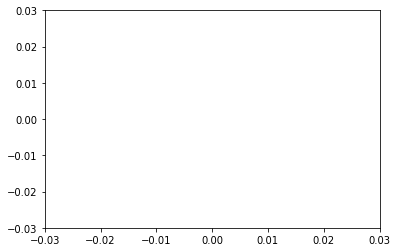

In [16]:
fig = plt.figure()  # Create a figure object
camera = Camera(fig)
ax = fig.add_subplot(1, 1, 1)  # Add a subplot to the figure

# Loop over time steps and create scatter plot
for current_time_step in range(total_time_steps):
    # Instead of clearing axis, directly update the plot data if possible
    scatter = ax.scatter(
        result_array[current_time_step, :, 0] + result_array[current_time_step, :, 2],
        result_array[current_time_step, :, 1] + result_array[current_time_step, :, 3],
        c=np.sqrt(result_array[current_time_step, :, 2]**2 + result_array[current_time_step, :, 3]**2),
        cmap='jet'
    )
    ax.set_xlim(-0.03, 0.03)  # Set appropriate x-axis limits
    ax.set_ylim(-0.03, 0.03)  # Set appropriate y-axis limits
    camera.snap()

# Create animation from captured frames
anim = camera.animate(blit=False)

# Save the animation as a GIF using PillowWriter
anim.save('scatter_plot_animation26.gif', writer='pillow', fps=60)